In [1]:
import sys, os
sys.path.insert(0, '..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
from tqdm import tqdm, trange
import gc
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.graph_utils import get_edges_fastknn_faiss
from utils.score import statistical_parity
from utils.snakemake_utils import FileResources

warnings.filterwarnings("ignore")
gc.enable()

/home/ashutosh/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

In [4]:
y = pokec_data.PokecDataFrame(group_col='gender').get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [5]:
sp_score, roc_score = {}, {}

# distributions of positive and negative edgeswith dot product

In [6]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

In [7]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

# GCN ( baseline)

In [8]:
model = "GCN_baseline"
emb = np.load(FileResources(root='/tmp/residual_2_vec/original_pokec/', crosswalk=False, baseline=True, model_name='gcn',).embs_file)
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((1632803, 128), (1632803, 128), (1632803, 128))

100%|███████████████████████████████████| 1632803/1632803 [00:02<00:00, 570133.46it/s]


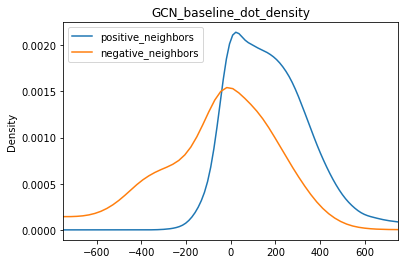

In [9]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# GCN ( baseline + crosswalk)

In [ ]:
model = "GCN_baseline_crosswalk"
emb = np.load(FileResources(root='/tmp/residual_2_vec/original_pokec/', crosswalk=True, baseline=True, model_name='gcn',).embs_file)
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# GCN ( r2v)

In [ ]:
model = "GCN_r2v"
emb = np.load(FileResources(root='/tmp/residual_2_vec/original_pokec/', crosswalk=True, baseline=True, model_name='gcn',).embs_file)
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# GCN ( r2v + crosswalk)

In [ ]:
model = "GCN_r2v_crosswalk"
emb = np.load(FileResources(root='/tmp/residual_2_vec/original_pokec/', crosswalk=True, baseline=True, model_name='gcn',).embs_file)
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# GAT

In [ ]:
model = 'GAT'
emb = np.load("../data/pokec_gat_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# GAT with Node2Vec Crosswalk weights(16 dim)

In [ ]:
model = 'GAT_crosswalk'
emb = np.load("../data/pokec_crosswalk_gat_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-100, 100)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# GCN with Node2Vec Crosswalk weights(16 dim)

In [ ]:
model = 'GCN_crosswalk'
emb = np.load("../data/pokec_crosswalk_gcn_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
ax.set_xlim(-200, 200)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
sp_score[model] = statistical_parity(edges, y)

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model]

# plot statistical parity scores

In [ ]:
import seaborn as sns
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [ ]:
import seaborn as sns
for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)